## Introduction

Gradient descent is a technique to train neural network parameters to make predictions from data.  In this notebook, we'll learn about gradient descent by using it to train a linear regression model.

Linear regression is a popular supervised machine learning algorithm that predicts a target given some predictors.  We'll use linear regression to predict tomorrow's temperature using historical data:

In [75]:
import pandas as pd

# Read in the data
data = pd.read_csv("../data/clean_weather.csv", index_col=0)
# Fill in any missing values in the data with past value
data = data.ffill()

# Show the first 5 rows of the data
data.head(5)

,tmax,tmin,rain,tmax_tomorrow
1970-01-01,60.0,35.0,0.0,52.0
1970-01-02,52.0,39.0,0.0,52.0
1970-01-03,52.0,35.0,0.0,53.0
1970-01-04,53.0,36.0,0.0,52.0
1970-01-05,52.0,35.0,0.0,50.0


In our data, each row is a different day, and the columns are different weather observations associated with that day.  We have data from `1970` to the present.

Using the data above, we could predict `tmax_tomorrow` based on today's max temperature (`tmax`), today's min temperature (`tmin`), and how much it rained today (`rain`).

Linear regression requires a linear relationship between the predictors and the target.  If two values have a linear relationship, when one value changes, the other value changes proportionally.  We can visualize this with a scatter plot:

<AxesSubplot: xlabel='tmax', ylabel='tmax_tomorrow'>

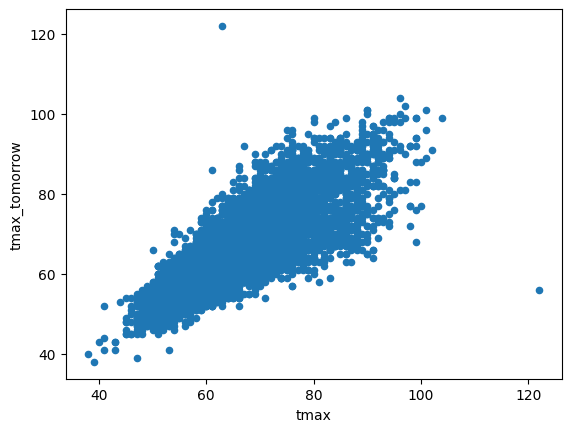

In [76]:
data.plot.scatter("tmax", "tmax_tomorrow")

As you can see above, `tmax` and `tmax_tomorrow` have a linear relationship - when `tmax` increases, `tmax_tomorrow` usually does as well.

Intuitively, if we drew a line through the center of the cloud of points, we could use that line to predict `tmax_tomorrow` from `tmax`.  Since `tmax` is linearly related to `tmax_tomorrow`, the line will tell us what number to multiply `tmax` by to get a prediction for`tmax_tomorrow`.


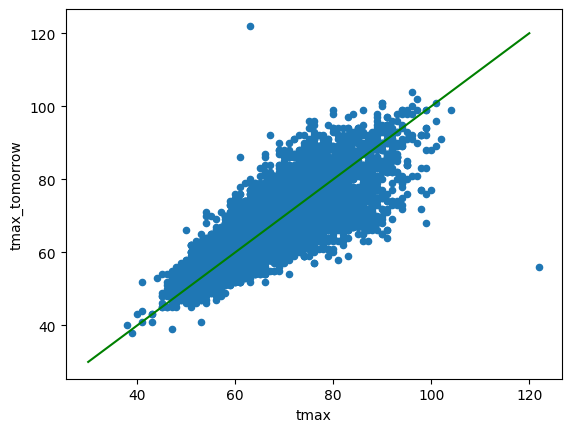

In [77]:
import matplotlib.pyplot as plt
data.plot.scatter("tmax", "tmax_tomorrow")

plt.plot([30,120], [30,120], 'green')

The above green line is multiplying `tmax` by `1` to get our predicted `tmax_tomorrow`.

Linear regression works in a similar way - it learns the correct values to multiply the predictors by to get the target.  The equation for this looks like:

$\hat{y}=w_{1}x_{1} + w_{2}x_{2} + w_{3}x_{4} + b$

- $\hat{y}$ is our prediction for `tmax_tomorrow`.
- $x_{1}$, $x_{2}$, and $x_{3}$ are the predictors that we're using to predict the target (in this case, `tmax`, `tmin`, and `rain`).  If we had more predictors, we would add more x values to our equation.
- The $w$ values are the weight parameters that the linear regression algorithm learns.  The weights are what we multiply the $x$ values by to get the predicted $\hat{y}$ value.
- $b$ is a value called the bias (or y-intercept).  This enables us to "shift" the prediction line up or down to match the data.  Without a bias, if our predictors are all `0`, then our prediction will also be `0`.

Let's take a look at how a linear regression model works.  To simplify things, we will go with just a single predictor (`tmax`).

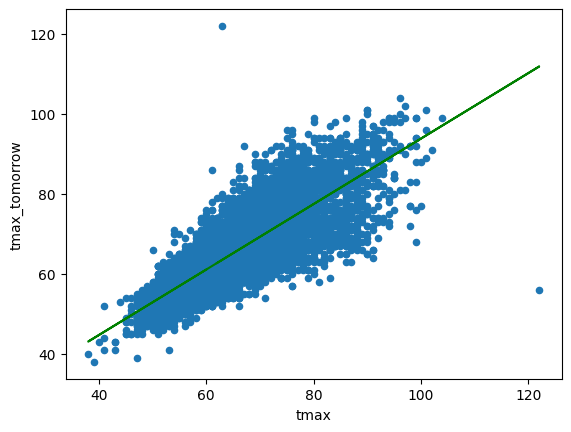

In [78]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Fit a linear regression model
lr = LinearRegression()
lr.fit(data[["tmax"]], data["tmax_tomorrow"])

# Plot our data points and the regression line
data.plot.scatter("tmax", "tmax_tomorrow")
plt.plot(data["tmax"], lr.predict(data[["tmax"]]), color="green")

In the above cell, we fit a linear regression model using a library called `scikit-learn`.  The data points are in blue, and the linear regression line (predicted temperatures) is in green.

We can take a look at the coefficients for the line below:

In [79]:
print(f"Weight: {lr.coef_[0]:.2f}")
print(f"Bias: {lr.intercept_:.2f}")

Weight: 0.82
Bias: 11.99


Our predictions for `tmax_tomorrow` will be $\hat{y}=.82 * \text{tmax} + 11.99$.  Now let's learn how to build our own linear regression algorithm.

Earlier, I mentioned that we'd train our linear regression algorithm using gradient descent.  To make gradient descent work, we first need to calculate our loss.

Let's say today's `tmax` is `80`.  Using the equation, we can calculate our predicted `tmax_tomorrow` to be `77.59`. Then we can calculate our loss.  Loss is a measure of the difference between the actual values and our predictions.  With linear regression, it's common to use squared error.  We calculate it using the formula $e=(\hat_{y} - y) ^ 2$.

If the actual `tmax_tomorrow` is `81`, then our loss is $(77.59 - 81) ^ 2$, which equals `11.63`.

Our parameters (weight and bias) led to this loss value.  If we change the weight, our loss will also change.  Let's visualize what it would look like if our weight value was `1`.


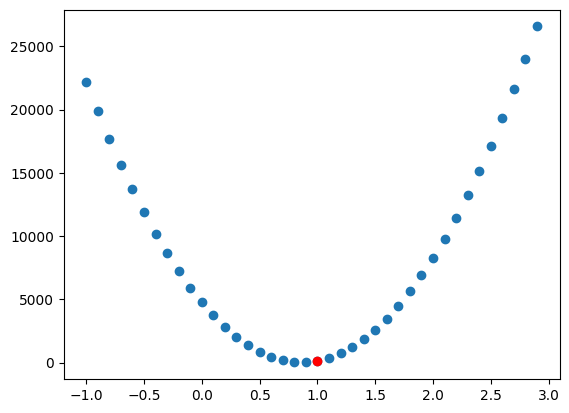

In [101]:
import numpy as np
# Function to calculate the loss
loss = lambda w,y: ((w * 80 + 11.99) - y) ** 2
# Actual temperature tomorrow
y = 81
# Calculate loss values for several weights
ws = np.arange(-1,3,.1)
losses = loss(ws, y)

# Plot the weight and losses
plt.scatter(ws, losses)
# Plot a weight of 1 and the corresponding loss
plt.plot(1, loss(1, y), 'ro')

In the plot above, we've graphed the weight values on the x-axis, and the corresponding losses on the y-axis.  As you can see, there is a value at the bottom of the graph where loss is the lowest.  Loss increases if the weight is higher or lower than that value.  This is called the global minimum, and it's our goal to reach this value.

We've marked our weight value of `1` in red.  It's close to the global minimum, but not quite there.  This is where gradient descent comes into play - it helps us adjust our parameters to reduce loss.

First, we calculate the loss when the weight is `1`.  This equals `120.78` - $((1 * 80 + 11.99) - 81) ^ 2$.  We then have to figure out how much each parameter contributes to that loss.

To understand how we do this, let's first take a look at the operations we perform to get a prediction:

![Operations](images/linreg/gradient.svg)

As you can see, we take our input data (`tmax`), multiply it by the weight $w$, then add in the bias $b$ to get our prediction.

To make the prediction closer to the correct value, we need to adjust $w$ and $b$.  We need to know how much to adjust them, and in which direction (up or down).

To figure this out, we take the partial derivative of the loss against $w$ and $b$.  This is a math way of saying "we're going to figure out how much each parameter contributes to our loss".

We start by calculating the gradient of our loss.  This tells us how quickly our loss is changing.  We want to move in the direction where loss is decreasing the fastest.  We can calculate this by taking the derivative of our loss metric, which is $2 * (\hat{y} - {y})$. This shows us how quickly our loss is changing:

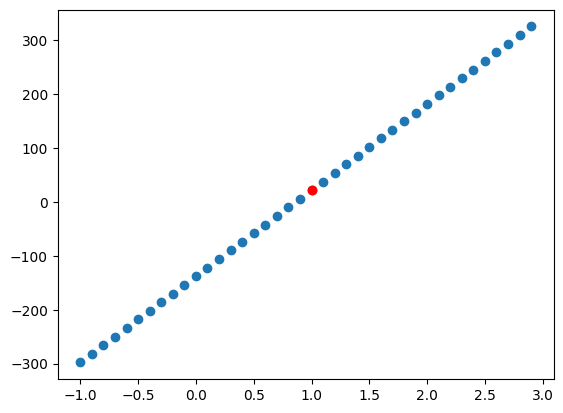

In [102]:
# Function to calculate the gradient
gradient = lambda w,y: ((w * 80 + 11.99) - y) * 2
# Calculate gradient values for several weights
gradients = gradient(ws, y)

# Plot the weight and gradients
plt.scatter(ws, gradients)
plt.plot(1, gradient(1,y), 'ro')

If our weight is above a certain value (around `.82`), then our gradient is positive, and our predictions are too large.  If it is below the value, then our gradient is negative, and our predictions are too small.  Our current gradient is `21.98` - $((1 * 80 + 11.99) - 81) * 2$

With gradient descent, our goal is to get to a place where the gradient is close to `0` (our predictions match the actual values).  Hopefully this area will be a global minimum. Sometimes it will be a local minimum instead, which we'll discuss further later on.

The partial derivative with respect to the loss gradient tells us how much to adjust each parameter to lower the loss.  First, let's take the partial derivative with respect to $b$:

$\frac{\partial L}{\partial b}=\partial L$

The intuitive way to think about this is "how would I change $b$ if I wanted to get the predictions closer to the actuals?".  Because you add $b$ to $x * w$ to get the prediction, any change to $b$ directly impacts the prediction.  So the partial derivative of $b$ with respect to the loss is the same as the loss!

![B derivative](images/linreg/b_deriv.svg)

Next, we take the partial derivative with respect to $w$.  This is a little more complicated, since we multiply $w$ by $x$, then add it to $b$ to get our prediction:

$\frac{\partial L}{\partial w}=\frac{\partial L}{\partial (x*w)}\frac{\partial (x*w)}{\partial w}$

We use the chain rule to find the derivative.  The chain rule says that the partial derivative of $a$ with respect to $c$ equals the partial derivative of $a$ with respect to $b$ times the partial derivative of $b$ with respect to $c$.

Similar to what we saw with $b$, $\frac{\partial L}{\partial (x*w)}$ is just the same as $\partial L$, since we add $x*w$ to $b$ to get the loss.

So we can update the equation to:

$\frac{\partial L}{\partial w}=\partial L\frac{\partial (x*w)}{\partial w}$

Since we multiply $w$ by $x$, any change to $w$ will change the prediction proportional to $x$.  So:

$\frac{\partial L}{\partial w}=\partial L * x$

![W derivative](images/linreg/w_deriv.svg)

After calculating the partial derivatives, we update our $w$ and $b$ values by subtracting the partial derivatives from the current values.  We don't want to subtract the entire partial derivative, though - this would change the weight too much:

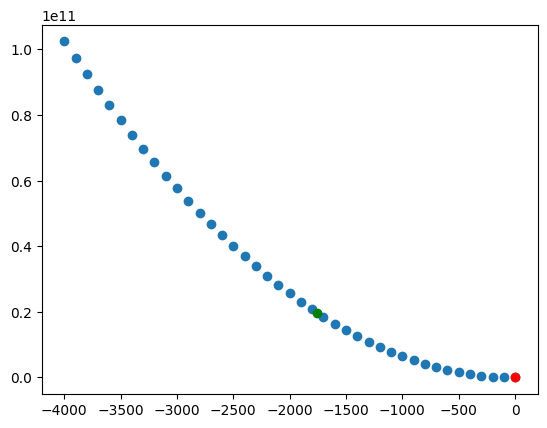

In [99]:
ws = np.arange(-4000,100,100)
losses = loss(ws, y)

# Plot the weight and losses
plt.scatter(ws, losses)

# Original weight
plt.plot(1, loss(1, y), 'ro')
# New weight
new_weight = 1-1758
plt.plot(new_weight, loss(new_weight, y), 'go')

Above, you can see the original weight in red, and the new weight is in green.  You might notice that the error is actually higher with the new weight.  This is because we took too large of a step.  This is a common problem with gradient descent - we adjust our parameters so much that we overshoot the minimum and end up with higher error.

This happens because the partial derivative doesn't know that the gradient will change in between the old weight value and the new weight value.  Since we're taking the derivative at a single point, it assumes that the gradient will stay constant.  Instead, as we can see in the chart below, the gradient changes quite a bit between the old weight and the new weight:

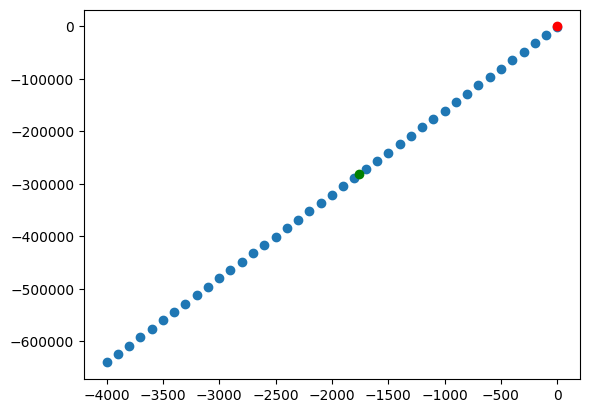

In [100]:
import numpy as np
# Calculate gradient values for several weights
gradients = gradient(ws, y)

# Plot the weight and gradients
plt.scatter(ws, gradients)
plt.plot(1, gradient(1, y), 'ro')
# New weight
plt.plot(new_weight, gradient(new_weight, y), 'go')

To adjust for this, we use a learning rate.  Instead of adjusting the weights and biases directly by the partial derivative, we multiply by the learning rate.  This enables us to take a smaller step, and stay in a region where the gradient doesn't change too much:

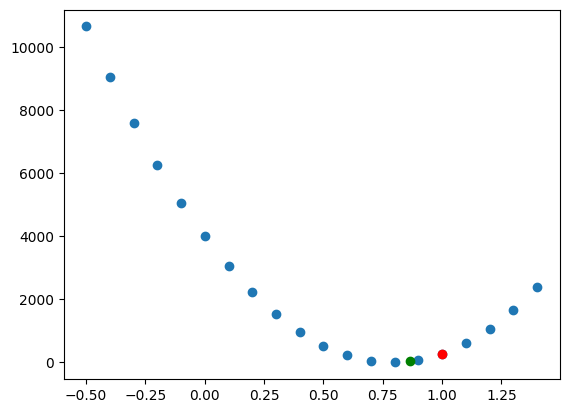

In [67]:
ws = np.arange(-.5,1.5,.1)
losses = loss(ws, y)

# Plot the weight and losses
plt.scatter(ws, losses)

# Original weight
plt.plot(1, 282.24, 'ro')
# New weight with learning rate
lr = 5e-5
new_weight = 1 - lr * 2688
plt.plot(new_weight, (new_weight * 80 + 14.07 - 77.27) ** 2, 'go')

The new weight is around `.86`, and has lower error than the original weight of `1`. Note that the gradient with the new weight is very different from the gradient with the original weight.  With a weight of `1`, it was `33.6`, but it is now `11.2`.  It's still not `0`, so we're not at a global minimum.

To get to the global minimum, we repeat gradient descent multiple times to "descend" to the correct weight and bias values.  The method looks like:

- Predict y using the current parameters
- Measure the gradient
- Update $w$ and $b$ using the partial derivative

We repeat until a local or global minimum, which has a gradient close to `0`.

Of course, in linear regression, we're looking at hundreds or thousands of rows, not just a single data point.  In this case, we loop through the entire data set, and do gradient descent on each row.  We then repeat this until the gradient averaged over the entire training set is close to 0.

We now know everything we need to get started implementing linear regression with gradient descent!

Let's first load our data and split it into 3 sets:

- A training set, which we'll use to train our algorithm
- A validation set, which we'll use to measure error during training
- A test set, which we'll use to evaluate the model after it has been fit

Creating separate sets like this helps us avoid overfitting, where our model looks great in training, but doesn't work in the real world.

In [52]:
import numpy as np
PREDICTORS = ["tmax", "tmin", "rain"]
TARGET = "tmax_tomorrow"

# Ensure we get the same split every time
np.random.seed(0)

split_data = np.split(data, [int(.7 * len(data)), int(.85 * len(data))])
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = [[d[PREDICTORS].to_numpy(), d[[TARGET]].to_numpy()] for d in
                                                            split_data]

To train a linear regression algorithm using gradient descent, we need 4 elements:

- A way to initialize our parameters (weights and biases)
- A `forward` pass that computes predictions using the parameters
- A loss function that measures the error of our predictions
- A `backward` pass that updates our parameters to reduce the loss

To initialize our weight parameters, we can use random initialization.  Random initialization helps the gradient descent algorithm descend to a global minimum efficiently (feel free to experiment with other initializations, like 0 or 1 to see what happens).

It's common to initialize the bias to be `1` or `0`.

We'll shrink the initial parameter values so we don't end up with predictions that are too large (this can cause gradient descent to take steps that are too large).

In [103]:
import math

def init_params(predictors):
    # Initialize model parameters
    # k is a scaling factor that we use to reduce the weights and biases initially
    k = math.sqrt(1 / predictors)
    # We set a random seed so if we re-run this code, we get the same results
    np.random.seed(0)
    weights = np.random.rand(predictors, 1) * 2 * k - k
    biases = np.ones((1, 1)) * 2 * k - k
    return  [weights, biases]

We initialize one $w$ value for each of our predictors (`tmax`, `tmin`, and `rain`).  We initialize one bias for each target variable.  In this case, we're only predicting one value for each row `tmax_tomorrow`, so we only have one bias.

In the forward pass of our network, we generate predictions by multiplying $w$ and $x$, then adding $b$:

In [104]:
def forward(params, x):
    weights, biases = params
    # Multiply x values by w values with matrix multiplication, then add b
    prediction = x @ weights + biases
    return prediction

Once we have predictions, we need to calculate error.  We have two functions, one to calculate the loss, and one to calculate the loss gradient (which helps us update our parameters):

In [105]:
def mse(actual, predicted):
    # Calculate mean squared error
    return np.mean((actual - predicted) ** 2)

def mse_grad(actual, predicted):
    # The derivative of mean squared error
    return predicted - actual

In the backward pass of the network, we adjust $w$ and $b$ by the partial derivative times learning rate.  We will make predictions for our whole training set, then average the gradient across the whole set to compute the updates.  This will ensure that a single training example doesn't pull the gradient too far in one direction or another.

In [106]:
def backward(params, x, lr, grad):
    # Multiply the gradient by the x values
    # Divide x by the number of rows in x to avoid updates that are too large
    w_grad = (x.T / x.shape[0]) @ grad
    b_grad = np.mean(grad, axis=0)

    params[0] -= w_grad * lr
    params[1] -= b_grad * lr

    return params

Finally, we'll write a loop that:

- Makes predictions for the whole training set
- Computes the gradient for each training example
- Updates the parameters based on the gradient

We will run the algorithm for several epochs - an epoch is each iteration over the training set.  Up to a point, more epochs will improve the accuracy.

We will print out the loss on the validation set regularly so we can monitor the loss.  We know we have too many epochs if the validation loss is increasing instead of decreasing.

In [113]:
lr = 1e-4
epochs = 50000
params = init_params(train_x.shape[1])

for i in range(epochs):
    predictions = forward(params, train_x)
    grad = mse_grad(train_y, predictions)

    params = backward(params, train_x, lr, grad)

    if i % 10000 == 0:
        predictions = forward(params, valid_x)
        valid_loss = mse(valid_y, predictions)

        print(f"Epoch {i} validation loss: {valid_loss}")

Epoch 0 validation loss: 297.27540770706065
Epoch 10000 validation loss: 22.647249675483117
Epoch 20000 validation loss: 22.613777406314743
Epoch 30000 validation loss: 22.581085439005864
Epoch 40000 validation loss: 22.549154158580198


We can display our parameters to see how the regression worked.  This will show the weights for each predictor, as well as the bias:

In [114]:
params

[array([[ 0.79210427],
        [ 0.2450347 ],
        [-0.06038591]]),
 array([[1.12700385]])]

We can also evaluate the algorithm on the test set to measure error:

In [115]:
predictions = forward(params, test_x)
mse(test_y, predictions)

23.335214564774653

You should now understand how gradient descent works to update parameters.  In this next notebook, we'll cover how to train a dense neural network using gradient descent!